In [2]:
!python -V

Python 3.9.13


In [3]:
import pandas as pd

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [5]:
%pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.0/39.0 MB 6.8 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
df2 = pd.read_parquet('./yellow_tripdata_2022-01.parquet')

In [18]:
df2.shape[0]

2463931

In [11]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [13]:
df.duration.describe()

count    2.463931e+06
mean     1.421220e+01
std      4.644531e+01
min     -3.442400e+03
25%      6.316667e+00
50%      1.018333e+01
75%      1.616667e+01
max      8.513183e+03
Name: duration, dtype: float64

In [14]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [19]:
df.shape[0] / df2.shape[0] * 100

98.27547930522405

In [20]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [21]:
df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_5801/1767203464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [22]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [24]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [27]:
len(train_dicts)

2421440

In [25]:
X_train

<2421440x516 sparse matrix of type '<class 'numpy.float64'>'
	with 7264320 stored elements in Compressed Sparse Row format>

In [29]:
len(dv.feature_names_)

516

In [30]:
target = 'duration'
y_train = df[target].values

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [32]:
y_pred = lr.predict(X_train)

In [33]:
mean_squared_error(y_train, y_pred, squared=False)

7.0014961794266

/home/msantalov/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msantalov/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


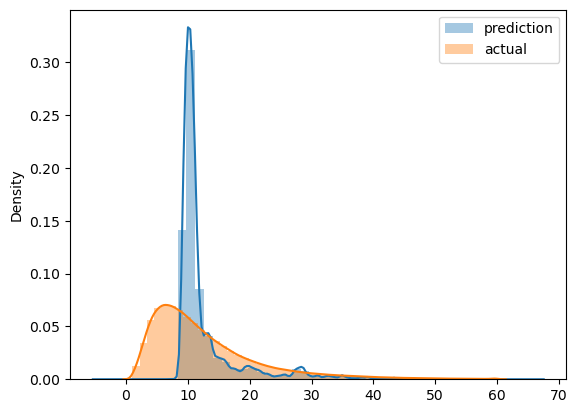

In [34]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [38]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [39]:
df_train = read_dataframe('./yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('./yellow_tripdata_2022-02.parquet')

In [40]:
len(df_train), len(df_val)

(2421440, 2918187)

In [41]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [42]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [43]:
dv = DictVectorizer()

In [44]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [45]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [46]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [50]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [53]:
y_pred = lr.predict(X_train)

In [54]:
mean_squared_error(y_train, y_pred, squared=False)

4.79726078148258

In [55]:
y_pred = lr.predict(X_val)

In [56]:
mean_squared_error(y_val, y_pred, squared=False)

5.530232639645586

In [ ]:
7.479513631630414

with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)